本示例使用Kaggle上的一个鸟类类别数据集，其包含400个类别的鸟类的图片，数据集地址：https://www.kaggle.com/datasets/gpiosenka/100-bird-species

导入需要用到的相关包

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

# 如果出现调用CUDA后调用matplotlib后kernel dead则需要加入此句代码
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# 开启CuDNN加速
cudnn.benchmark = True

# 使用动态图（即图像会进行更新）
plt.ion()

读入图片数据集

In [2]:
# 图像转换（使用transforms.Compose组合两个步骤：先图像转成Tensor->然后图像标准化）
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# 数据集地址（下载数据集后减压，将解压后内容存在Birds_Datasets文件夹下）
# 该数据集内包含‘train’,'valid'三个文件夹，分别对应训练集和验证集
data_dir = 'Birds_Datasets/'

# 使用ImageFolder构造用于model的数据集，传入data_transforms对图像进行转换
# image_datasets为一个字典文件，内部包含‘train’和‘valid’两个数据集
# 每个数据集包含三个属性：classes(list保存的类别名称), class_to_idx(类别对应的索引), imgs(保存图片地址和类别索引的tuple的list)
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'valid']}

# 使用DataLoader传入datasets构建数据导入器
# batch_size=16代表每次传入16张图片作为一个batch
# num_works=4代表使用4个子进程导入数据
# 当前数据集已经被分成很多个batches
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'valid']}

# 查看数据集的样本量并打印
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
print(dataset_sizes)

# 读取400个类别的标签名称
class_names = image_datasets['train'].classes

# 如果有CUDA可用则后续程序使用GPU运行，无则使用CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

{'train': 58388, 'valid': 2000}
cuda:0


查看/绘制导入的图片数据集

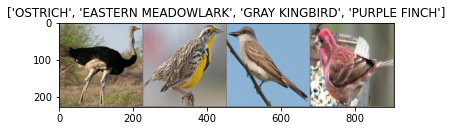

In [3]:
# 定义画图函数
def imshow(inp, title=None):
    
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

# 获取一个batch的训练数据
inputs, classes = next(iter(dataloaders['train']))

# 提取batch里的前四张，组成一张网格图像
out = torchvision.utils.make_grid(inputs[:4])

# 调用画图函数画图
imshow(out, title=[class_names[x] for x in classes[:4]])

定义新的模型，这里基于已经在ImageNet上训练过的AlexNet模型进行修改  
仅需要修改最后的全连接层与Bird Species数据集的类别数相匹配

In [4]:
# 加载预训练过的AlexNet模型
model = models.alexnet(weights = 'AlexNet_Weights.DEFAULT')

# 如果需要固定卷积层部分的权重，则在定义新的全连接层前加入以下两行代码:
#for param in model.parameters():
#    param.requires_grad = False

# 基于原AlexNet的模型结构，修改全连接层
# 相当于重写classifier部分，但实际只是修改最后的输出层为400个类别
model.classifier = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(9216, 4096, bias = True),
    nn.ReLU(inplace = True),
    nn.Dropout(0.5),
    nn.Linear(4096, 4096, bias = True),
    nn.ReLU(inplace = True),
    nn.Linear(4096, 400)
)

# 设定对应设备（GPU or CPU）来运行
model = model.to(device)

# 定义损失函数
criterion = nn.CrossEntropyLoss()

# 定义优化方法
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# 定义学习率更新方法，每10个epoches学习率乘以0.1
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)

定义模型训练的函数

In [5]:
# 定义用于训练模型的函数
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    
    # 获取当前时刻的时间
    since = time.time()
    
    # 定义变量存储最佳模型的权重，初始值为当前初始模型的权重
    best_model_wts = copy.deepcopy(model.state_dict())
    # 定义变量存储模型分类正确率，初始值为0
    best_acc = 0.0
    
    # 对epoch进行循环
    for epoch in range(num_epochs):
        
        # 打印当前epoch的信息
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # 对训练和验证两个阶段进行循环
        # 每一个epoch都需要先训练模型，再验证模型
        for phase in ['train', 'valid']:
            
            # 如果当前为训练阶段，则把模型模式设为'train'
            if phase == 'train':
                model.train()
            else:
                model.eval()   # Set model to evaluate mode

            # 定义变量存储每次epoch的loss
            running_loss = 0.0
            # 定义变量存储每次epoch的分类正确次数
            running_corrects = 0

            # 对数据进行迭代（每次一个batch，dataloaders已经提前划分好）
            for inputs, labels in dataloaders[phase]:
                
                # 设定对应设备（GPU or CPU）来运行
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 设定初始参数梯度为0
                optimizer.zero_grad()

                # forward
                # track history if only in train
                # 如果是训练阶段则开启梯度计算，如果是验证阶段则关闭梯度计算
                with torch.set_grad_enabled(phase == 'train'):
                    # 传入数据提取模型的输出
                    outputs = model(inputs)
                    # 按行求各行的最大值对应的值和索引
                    # outputs的shape是[batch_size, 400]，目标是获得每个sample的模型预测最大可能性结果
                    _, preds = torch.max(outputs, 1)
                    # 计算loss
                    loss = criterion(outputs, labels)

                    # 近训练阶段进行反向传播
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 累计loss
                # 获取loss的值 再乘以 batch_size
                # 因为criterion计算得到的loss是对batch_size平均后的结果
                # 计算总loss时需要乘以batch_size
                running_loss += loss.item() * inputs.size(0)
                # 累计分类正确的次数
                running_corrects += torch.sum(preds == labels.data)
                
            # 对scheduler计数
            if phase == 'train':
                scheduler.step()

            # 计算该epoch的loss
            # 累计loss除以总样本数，得到平均loss
            epoch_loss = running_loss / dataset_sizes[phase]
            # 计算该epoch的正确率
            # 累计正确次数除以总样本数
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            # 打印Loss和Acc (分别对train和valid的结果进行输出)
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # 如果当前epoch验证集的正确率比之前都高，就存储当前模型权重
            # 将最优验证集正确率模型的权重存入bast_model_wts
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    #计算总的运行时间并打印时长和最佳验证集正确率
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # 加载最佳模型权重
    model.load_state_dict(best_model_wts)
    
    # 返回最佳模型
    return model

模型训练

In [ ]:
model = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 2.9019 Acc: 0.3923
valid Loss: 0.8153 Acc: 0.7910
Epoch 1/24
----------
train Loss: 1.0772 Acc: 0.7230
valid Loss: 0.4940 Acc: 0.8760
Epoch 2/24
----------
train Loss: 0.7077 Acc: 0.8095
valid Loss: 0.4034 Acc: 0.8905
Epoch 3/24
----------
train Loss: 0.5130 Acc: 0.8557
valid Loss: 0.3846 Acc: 0.9010
Epoch 4/24
----------
train Loss: 0.3940 Acc: 0.8870
valid Loss: 0.3183 Acc: 0.9110
Epoch 5/24
----------
train Loss: 0.3118 Acc: 0.9082
valid Loss: 0.3052 Acc: 0.9205
Epoch 6/24
----------
train Loss: 0.2553 Acc: 0.9253
valid Loss: 0.2730 Acc: 0.9215
Epoch 7/24
----------
train Loss: 0.2248 Acc: 0.9326
valid Loss: 0.3140 Acc: 0.9170
Epoch 8/24
----------
train Loss: 0.1877 Acc: 0.9431
valid Loss: 0.3247 Acc: 0.9175
Epoch 9/24
----------
train Loss: 0.1608 Acc: 0.9506
valid Loss: 0.2817 Acc: 0.9320
Epoch 10/24
----------
train Loss: 0.0556 Acc: 0.9824
valid Loss: 0.2258 Acc: 0.9460
Epoch 11/24
----------


可视化查看单个图片的分类结果

In [ ]:
# 定义可视化函数
# 可视化6张图片的结果
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

visualize_model(model_ft)